**Table of Contents:**

>[About task](#scrollTo=Oga1CrB_y5qt)

>[Required libraries](#scrollTo=UJ-nlNIBupvB)

>[Dataset](#scrollTo=l454S1YfvLHA)

>[CNN Model](#scrollTo=ko2GnWk4sYEx)

>[Performance Measurements](#scrollTo=lvebIlUlvfOi)

>[References](#scrollTo=grXx-hQWwPN-)



# About task
---
The project task for Quantum Machine Learning for Conspicuity Detection in Production requires the implementation of a Quantum Machine Learning Model to detect anomalies in production. In this notebook, I will implement a Classical CNN Model to classify all provided classes using all given data. This CNN model is one of my previous implementations used to detect tumors in brain MRI images. In the next notebooks, I will implement the QML model. My contributions to this task include:

- **Dataset:** Downloading the dataset from Kaggle to Colab and importing it with the correct path was a tedious job. The actual dataset contains 6 classes of 22,638 training data and 5,581 testing data. The model was trained with the whole training data, and 10% was used to validate the training process. The final performance was measured using all the testing data.

- **Preprocessing:** Image dimension was reduced and preprocessing was done to make it work within the limited resources.

- **Hyper-Parameter Tuning:** ReduceLROnPlateau was implemented to optimize the learning rate, and CSVLogger was used to record the training process. The best-performing model was saved in keras format and used to measure the performance with testing data.

- **Performance Measurements:** Overall Accuracy (OA), Average Accuracy (AA), Kappa Score, and ROC curve were implemented to measure the model performance.

# Required libraries

In [ ]:
import json
import os
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.utils import shuffle
from collections import Counter

import zipfile
import shutil
import cv2

import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from keras import models
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, CSVLogger

from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [1]:
from google.colab import userdata

os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# for gpu advantage

os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import warnings
warnings.filterwarnings('ignore')

1 Physical GPUs, 1 Logical GPUs


# Dataset

In [4]:
! kaggle datasets download -d danielbacioiu/tig-aluminium-5083

! unzip -q "tig-aluminium-5083.zip"

Dataset URL: https://www.kaggle.com/datasets/danielbacioiu/tig-aluminium-5083
License(s): CC-BY-SA-4.0
tig-aluminium-5083.zip: Skipping, found more recently modified local copy (use --force to force download)
replace al5083/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
'''
from README
-------------------------
Multiclass labels
-------------------------
good weld           0
burn through        1
contamination       2
lack of fusion      3
misalignment        4
lack of penetration 5

'''
# configs
epoch = 50
batch_size = 32
img_size = 128
labels = {0:'good_weld', 1:'burn_through', 2:'contamination', 3:'lack_of_fusion', 4:'misalignment', 5:'lack_of_penetration'}
classes = ['good_weld', 'burn_through', 'contamination', 'lack_of_fusion', 'misalignment', 'lack_of_penetration']

In [6]:
loc = "/content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_5"
Exp = "task_5.1_cnn"

In [7]:
root_path = '/content/al5083/'
# Opening JSON file
f1 = open(root_path + 'train/train.json')
f2 = open(root_path + 'test/test.json')

tr_data = json.load(f1)

class_dict_tr = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
for id, (key, value) in enumerate(tr_data.items()):
    class_dict_tr[value] += 1

te_data = json.load(f2)

class_dict_te = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
for id, (key, value) in enumerate(te_data.items()):
    class_dict_te[value] += 1


# Closing file handle
f1.close()
f2.close()

In [8]:
print("Training Data:")
sum_tr = 0
sum_te = 0
for i in [0,1,2,4,5]:
    sum_tr+=class_dict_tr[i]
    print(labels[i], ':',class_dict_tr[i])
print(f'\n\nTotal training data: {sum_tr}')


print("\n\nTesting Data:")
for i in [0,1,2,4,5]:
    sum_te+=class_dict_te[i]
    print(labels[i], ':', class_dict_te[i])
print(f'\n\nTotal testing data: {sum_te}')

Training Data:
good_weld : 8758
burn_through : 1783
contamination : 6325
misalignment : 2953
lack_of_penetration : 2819


Total training data: 22638


Testing Data:
good_weld : 2189
burn_through : 351
contamination : 2078
misalignment : 729
lack_of_penetration : 234


Total testing data: 5581


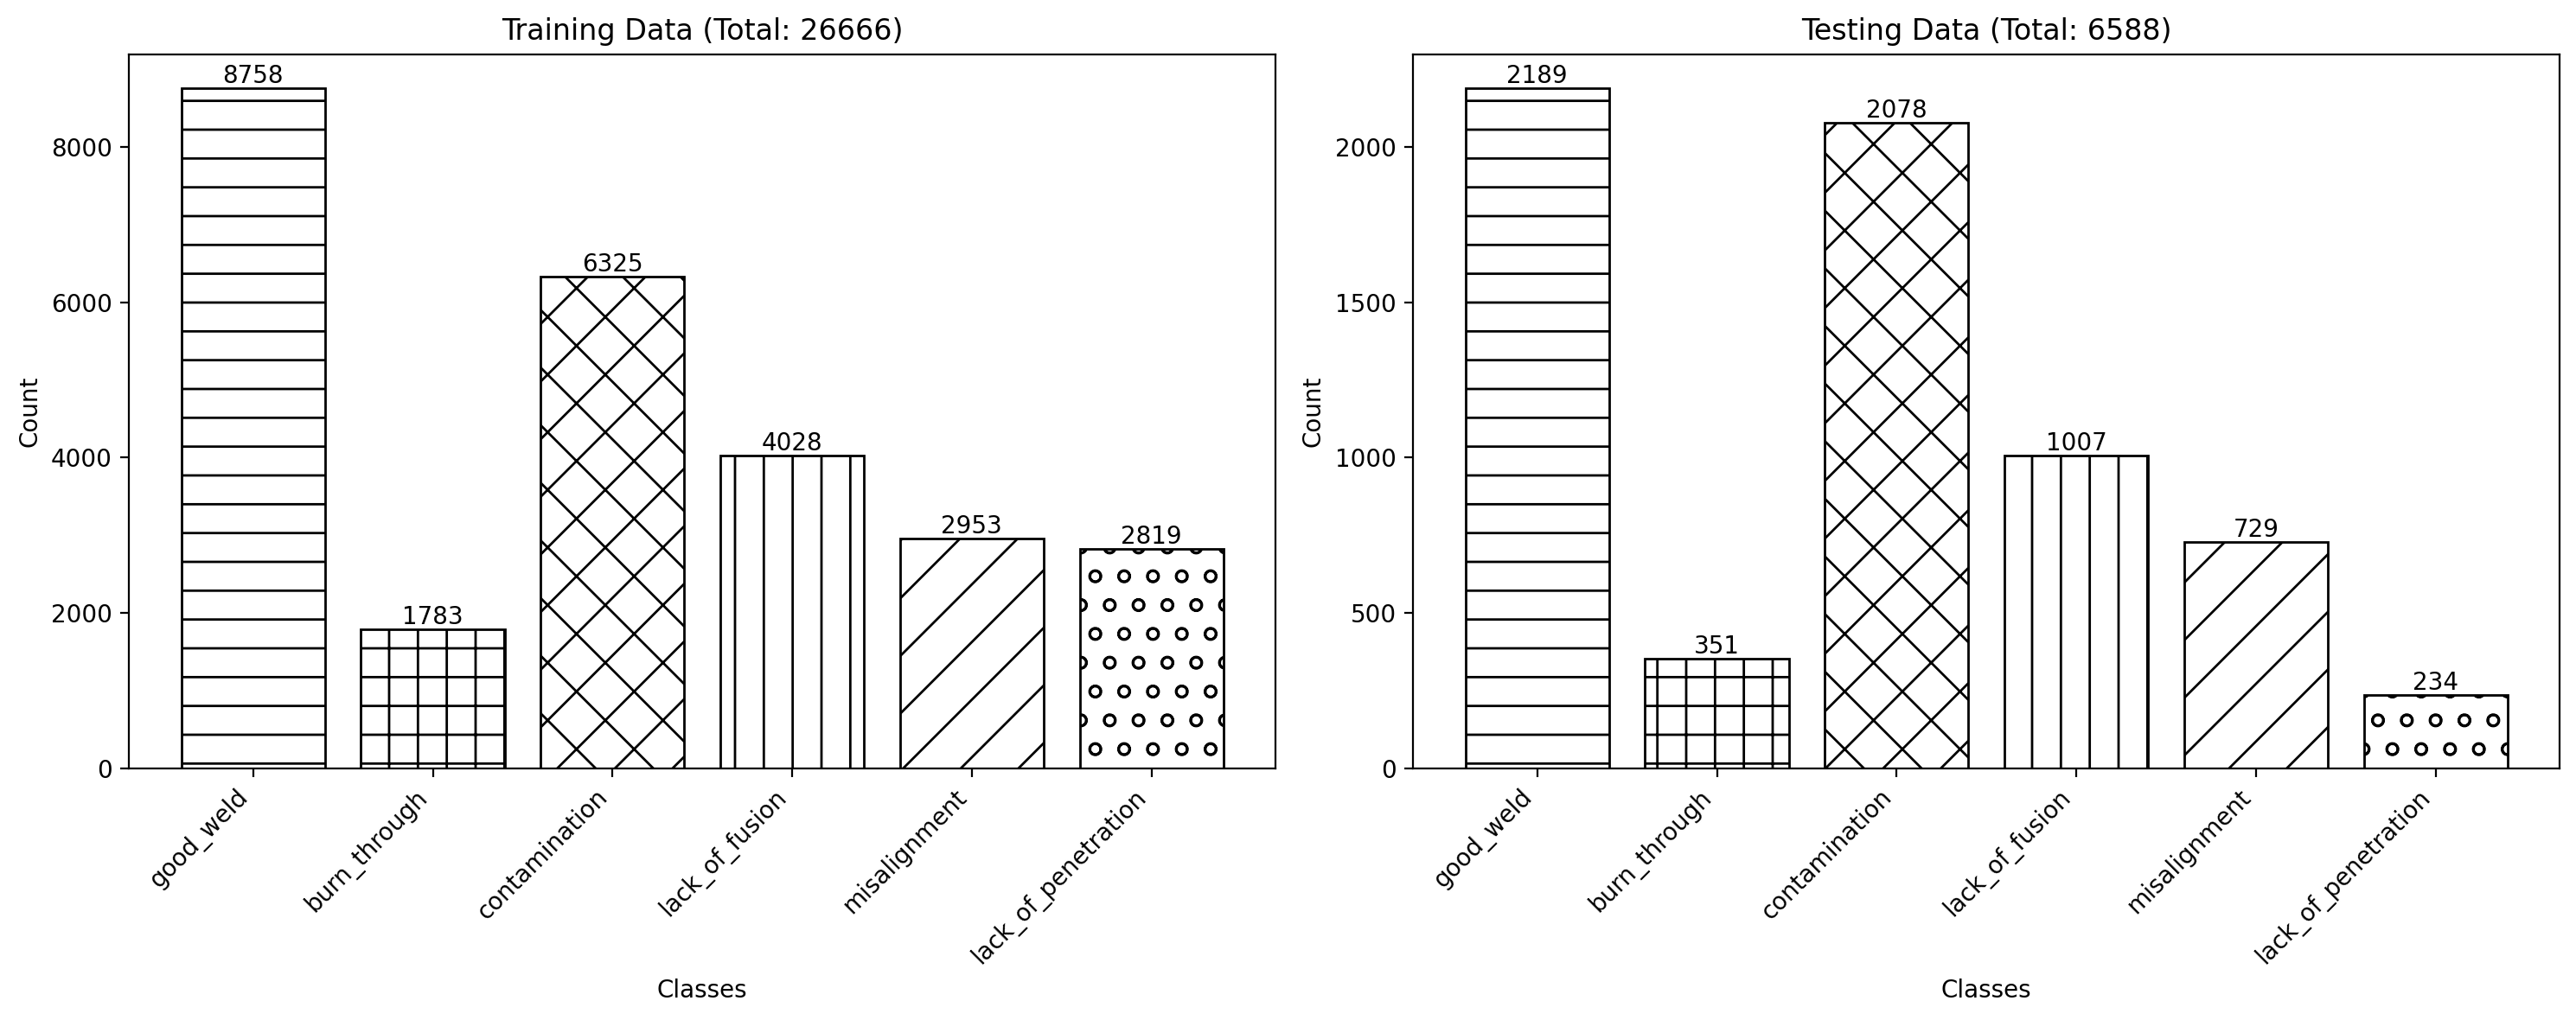

In [9]:
# Function to prepare data and labels
def prepare_data(class_dict, labels):
    x = class_dict.keys()
    classes = [labels[i] for i in x]
    values = list(class_dict.values())
    total = sum(values)
    return classes, values, total

# Prepare training data
classes_tr, values_tr, total_tr = prepare_data(class_dict_tr, labels)

# Prepare testing data
classes_te, values_te, total_te = prepare_data(class_dict_te, labels)

# Set up the plot with DPI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=200)

# Define hatch patterns
hatches = ['-', '+', 'x', '|', '/', 'o', '//', 'O', '.', '*']

# Function to add value labels on top of bars
def add_value_labels(ax, values):
    for i, v in enumerate(values):
        ax.text(i, v, str(v), ha='center', va='bottom')

# Plot training data
bars1 = ax1.bar(range(len(classes_tr)), values_tr, align='center', color='white', edgecolor='black')
for bar, hatch in zip(bars1, hatches * (len(classes_tr) // len(hatches) + 1)):
    bar.set_hatch(hatch)
ax1.set_xticks(range(len(classes_tr)))
ax1.set_xticklabels(classes_tr, rotation=45, ha='right')
ax1.set_title(f'Training Data (Total: {total_tr})')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Count')
add_value_labels(ax1, values_tr)

# Plot testing data
bars2 = ax2.bar(range(len(classes_te)), values_te, align='center', color='white', edgecolor='black')
for bar, hatch in zip(bars2, hatches * (len(classes_te) // len(hatches) + 1)):
    bar.set_hatch(hatch)
ax2.set_xticks(range(len(classes_te)))
ax2.set_xticklabels(classes_te, rotation=45, ha='right')
ax2.set_title(f'Testing Data (Total: {total_te})')
ax2.set_xlabel('Classes')
ax2.set_ylabel('Count')
add_value_labels(ax2, values_te)

plt.tight_layout()
plt.savefig(f"{loc}/Figures/{Exp}_dataset_classes.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
X_train = []
y_train = []

X_test = []
y_test = []

f1 = open(root_path + 'train/train.json')
f2 = open(root_path + 'test/test.json')

tr_data = json.load(f1)
te_data = json.load(f2)

for file_path, label in tr_data.items():
    img_path = os.path.join(root_path, 'train', file_path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))

    X_train.append(img)
    y_train.append(label)

for file_path, label in te_data.items():
    img_path = os.path.join(root_path, 'test', file_path)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))

    X_test.append(img)
    y_test.append(label)

In [11]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [12]:
# One Hot Encoding

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
X_train = X_train.reshape((X_train.shape[0],img_size,img_size,1))
X_test = X_test.reshape((X_test.shape[0],img_size,img_size,1))

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(26666, 128, 128, 1) (26666, 6)
(6588, 128, 128, 1) (6588, 6)


In [15]:
X_train[0].shape

(128, 128, 1)

In [16]:
# Let's shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=92)
X_test, y_test = shuffle(X_test, y_test, random_state=92)

In [17]:
def show_few_images(X = X_train, y = y_train, class_mapping = labels, number_of_examples=2, predict_using_model=None, distance_factor=0.5):
    num_classes = y.shape[1]
    figure1, ax1 = plt.subplots(number_of_examples, num_classes, figsize=(20, 5*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0

    for i in range(num_classes):
        # Find indices where the i-th class is 1 (true)
        class_indices = np.where(y[:, i] == 1)[0]
        if len(class_indices) > 0:
            # Sort the indices to ensure consistent spacing
            class_indices.sort()

            # Calculate the step size for index selection
            step = max(1, int(len(class_indices) * distance_factor))

            for j in range(number_of_examples):
                # Select an index with a large step size
                index = (j * step) % len(class_indices)
                selected_index = class_indices[index]

                image = X[selected_index]

                ax1[axs].imshow(image.squeeze(), cmap="gray")
                true_class = class_mapping[i]
                title = f'True: {true_class}'

                if predict_using_model:
                    result = predict_using_model.predict(np.expand_dims(image, axis=0))
                    acc = str(round(np.max(result)*100, 3))
                    predicted_classname = class_mapping[np.argmax(result)]
                    title += f'\nPrediction: {predicted_classname} - {acc}%'

                ax1[axs].set_title(title)
                axs += 1
        else:
            ax1[axs].set_title(f'No images for class {class_mapping[i]}')
            axs += 1

    plt.tight_layout()
    plt.savefig(f"{loc}/Figures/{Exp}_example_images.jpg", dpi=300, bbox_inches='tight')

    plt.show()

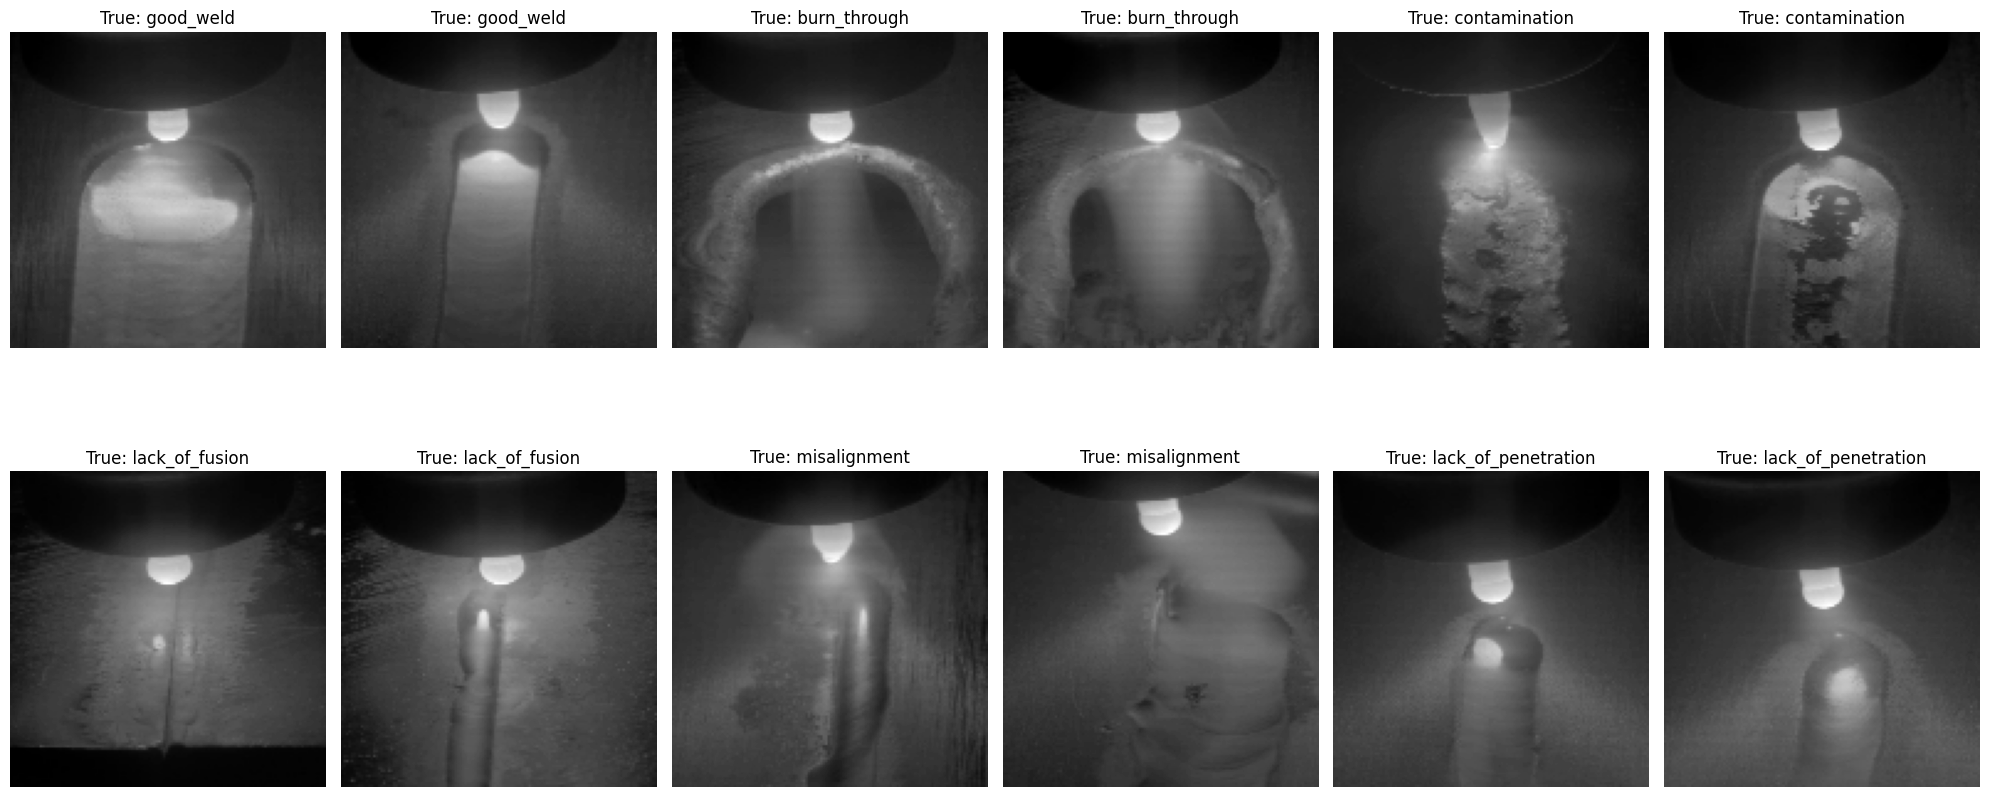

In [18]:
show_few_images(number_of_examples=2)

# CNN Model

In [19]:
def build_model(input_shape=(img_size, img_size, 1), n_classes = 6, optimizer='adam', isSVM=0):

    sequential_model = Sequential(
        [
            layers.Conv2D(32, (3, 3), input_shape=input_shape, activation="relu", name="Conv1"),
            layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_1"),

            layers.Conv2D(32, (3, 3), activation="relu", name="Conv2"),
            layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_2"),

            layers.Conv2D(64, (3, 3), activation="relu", name="Conv3"),
            layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_3"),

            layers.Flatten(),
            layers.Dense(512, activation="relu", name="fc1"),
            layers.Dropout(0.5)

        ]
    )
    # cnn + fc perceptron
    if isSVM==0:
        sequential_model.add(Dense(n_classes, activation="softmax", name="fc2"))
        sequential_model.compile(
                  optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    # cnn + svm
    else:
        sequential_model.add(Dense(n_classes, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation="softmax", name="svm"))
        sequential_model.compile(optimizer=optimizer,
                  loss='squared_hinge',
                  metrics=['acc'])

    return sequential_model
cnn_model = build_model(isSVM=0)
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_1 (MaxPooling2D)            │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 61, 61, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_2 (MaxPooling2D)            │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Max_Pool_3 (MaxPooling2D)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,454,182 (24.62 MB)

 Trainable params: 6,454,182 (24.62 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint_path = f"{loc}/Models/{Exp}.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=1,
                                       save_best_only=True,
                                       monitor = 'val_loss',
                                       mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.8,
                                        patience=5,
                                        cooldown=1,
                                        verbose=1,
                                        mode='auto',
                                        min_lr=1e-4,
                                        min_delta=0.0001),
    # tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    CSVLogger(f"{loc}/Models/{Exp}.log", separator=',', append=False)
]

In [21]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        fill_mode="nearest",
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1
)
test_datagen = ImageDataGenerator(
        rescale=1./255
)


train_ds = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True,
  batch_size=batch_size)


In [22]:
val_ds = train_datagen.flow(
  X_train, y_train,
  subset="validation",
  shuffle=True,
  batch_size=batch_size)


In [23]:
test_ds = test_datagen.flow(
  X_test, y_test,
  shuffle=False,
  batch_size=batch_size)


In [24]:
history = cnn_model.fit(train_ds,
                               epochs=epoch,
                               verbose=1,
                               validation_data = val_ds,
                               callbacks=callbacks)

Epoch 1/50
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - acc: 0.7373 - loss: 0.6699
Epoch 1: val_loss improved from inf to 0.13978, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_5/Models/task_5.1_cnn.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - acc: 0.7380 - loss: 0.6684 - val_acc: 0.9490 - val_loss: 0.1398 - learning_rate: 0.0010
Epoch 2/50
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - acc: 0.9504 - loss: 0.1417
Epoch 2: val_loss improved from 0.13978 to 0.05569, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_5/Models/task_5.1_cnn.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - acc: 0.9504 - loss: 0.1417 - val_acc: 0.9831 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 3/50
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - acc: 0.9753 - loss: 0.0760
Epoch 3: val_loss improved from 0.05569 to 0.03284, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_5/Models/task_5.1_cnn.keras
750/750 ━━━━━━━

# Performance Measurements

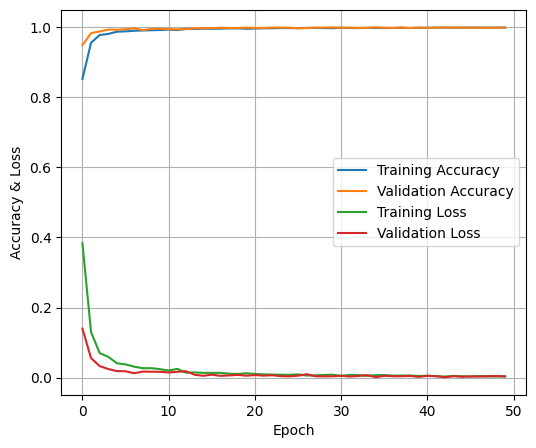

In [25]:
############ load trained model ################
# cnn_model = keras.models.load_model(f"{loc}/Models/{Exp}.hdf5", compile=False)

history = pd.read_csv(f"{loc}/Models/{Exp}.log", sep=',', engine='python')

############### ########## ####### #######

acc=history['acc']
val_acc=history['val_acc']


loss = history['loss']
val_loss = history['val_loss']


epochs_range=range(len(acc))

plt.figure(figsize=(6, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Accuracy & Loss")
plt.legend()
plt.grid()

plt.savefig(f"{loc}/Figures/{Exp}_acc_loss.jpg", dpi=500, bbox_inches='tight')
plt.show()

In [26]:
cnn_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = cnn_model.evaluate(test_ds, batch_size=32, callbacks= callbacks)
print("test loss: %.2f, test acc: %.2f"%(test_loss, test_acc))

Evaluate on test data
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6505 - loss: 6.8800
test loss: 6.89, test acc: 0.64


In [27]:
labels_pred= cnn_model.predict(test_ds)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [28]:
y_pred = tf.argmax(labels_pred, axis=1)

In [29]:
y_true = tf.argmax(y_test, axis = 1)

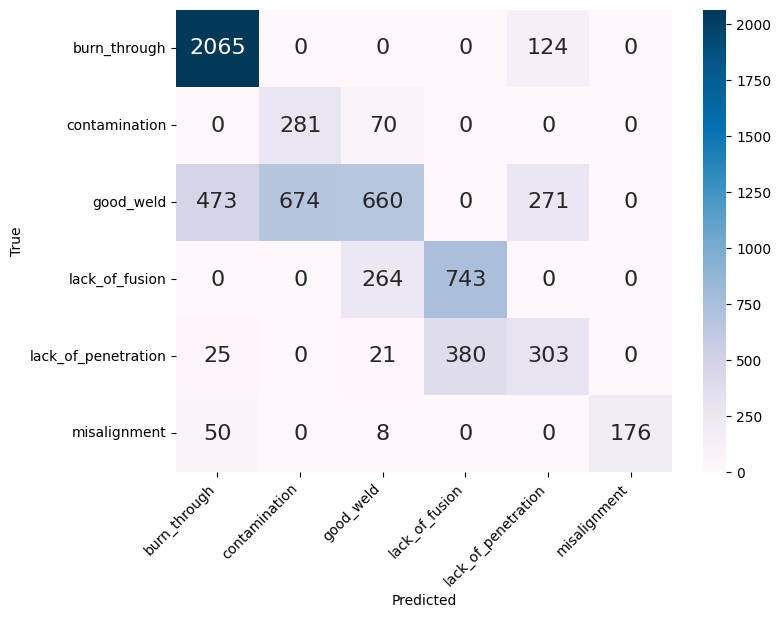

In [30]:
confusion = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion, columns=np.unique(classes), index = np.unique(classes))
df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8, 6))
# sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="PuBu", annot=True,annot_kws={"size": 16}, fmt='d')
plt.xticks(rotation=45, ha='right')


plt.savefig(f"{loc}/Figures/{Exp}_CM.jpg", bbox_inches='tight', dpi=300)
plt.show()
# plt.close()

In [31]:
# Calculate overall accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Calculate Cohen's kappa (Kappa)
kappa = cohen_kappa_score(y_true, y_pred)

# Calculate average accuracy (AA)
accuracies = []
for i in range(len(Counter(np.array(y_pred)))):
    accuracies.append(accuracy_score(y_true[y_true==i], y_pred[y_true==i]))
aa = sum(accuracies) / len(accuracies)

# # Matthew’s correlation coefficient
# print("Matthew’s correlation coefficient: %.3f"%matthews_corrcoef(y_true, y_pred))


print("Overall Accuracy (OA): {:.2f}%".format(oa*100))
print("Cohen's Kappa: {:.4f}%".format(kappa*100))
print("Average Accuracy (AA): {:.2f}%".format(aa.mean()*100))

Overall Accuracy (OA): 64.18%
Cohen's Kappa: 53.6444%
Average Accuracy (AA): 66.12%


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


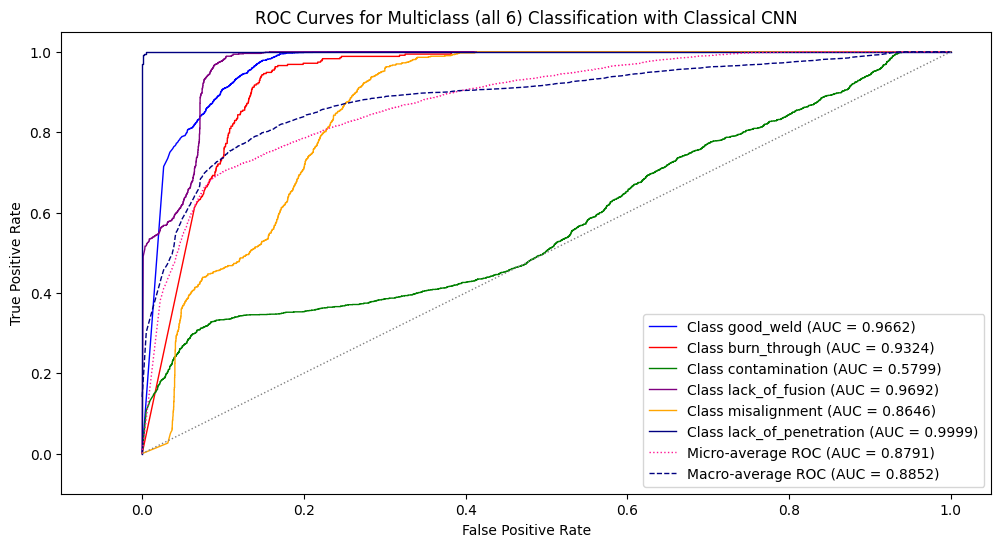

In [32]:
# Predict probabilities for each class
y_pred_prob = cnn_model.predict(test_ds)

# Binarize the true labels
my_labels = [i for i in range(len(classes))]
y_test_bin = label_binarize(y_test, classes=np.arange(len(my_labels)))

# Initialize variables for ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(my_labels)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(my_labels)
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(12, 6))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'navy']  # You can add more colors as needed
for i in range(len(my_labels)):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=1, label='Class {0} (AUC = {1:.4f})'.format(labels[i], roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=1, linestyle=':', label='Micro-average ROC (AUC = {0:.4f})'.format(roc_auc_micro))

# Plot macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='navy', lw=1, linestyle='dashed', label='Macro-average ROC (AUC = {0:.4f})'.format(roc_auc_macro))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='dotted')
plt.xlim([-0.1, 1.05])
plt.ylim([-0.1, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass (all 6) Classification with Classical CNN')
plt.legend(loc='lower right')
plt.savefig(f"{loc}/Figures/{Exp}_ROC_AUC_OVR2.jpg", dpi=500, bbox_inches='tight')

plt.show()

**Observation:**

- The model can classify the *lack_of_penetration, lack_of_fusion, good_weld, and burn_through* classes just fine.
- But it can not detect *contamination* at all. (~50\% AUC score).

In [33]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k, v in roc_auc.items():
    avg_roc_auc += roc_auc[k]
    i += 1
    print(f"Class {classes[k]}: ROC AUC OvR: {v:.4f}")
print(f"Average ROC AUC OvR: {avg_roc_auc/i:.4f}")

Class good_weld: ROC AUC OvR: 0.9662
Class burn_through: ROC AUC OvR: 0.9324
Class contamination: ROC AUC OvR: 0.5799
Class lack_of_fusion: ROC AUC OvR: 0.9692
Class misalignment: ROC AUC OvR: 0.8646
Class lack_of_penetration: ROC AUC OvR: 0.9999
Average ROC AUC OvR: 0.8854


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


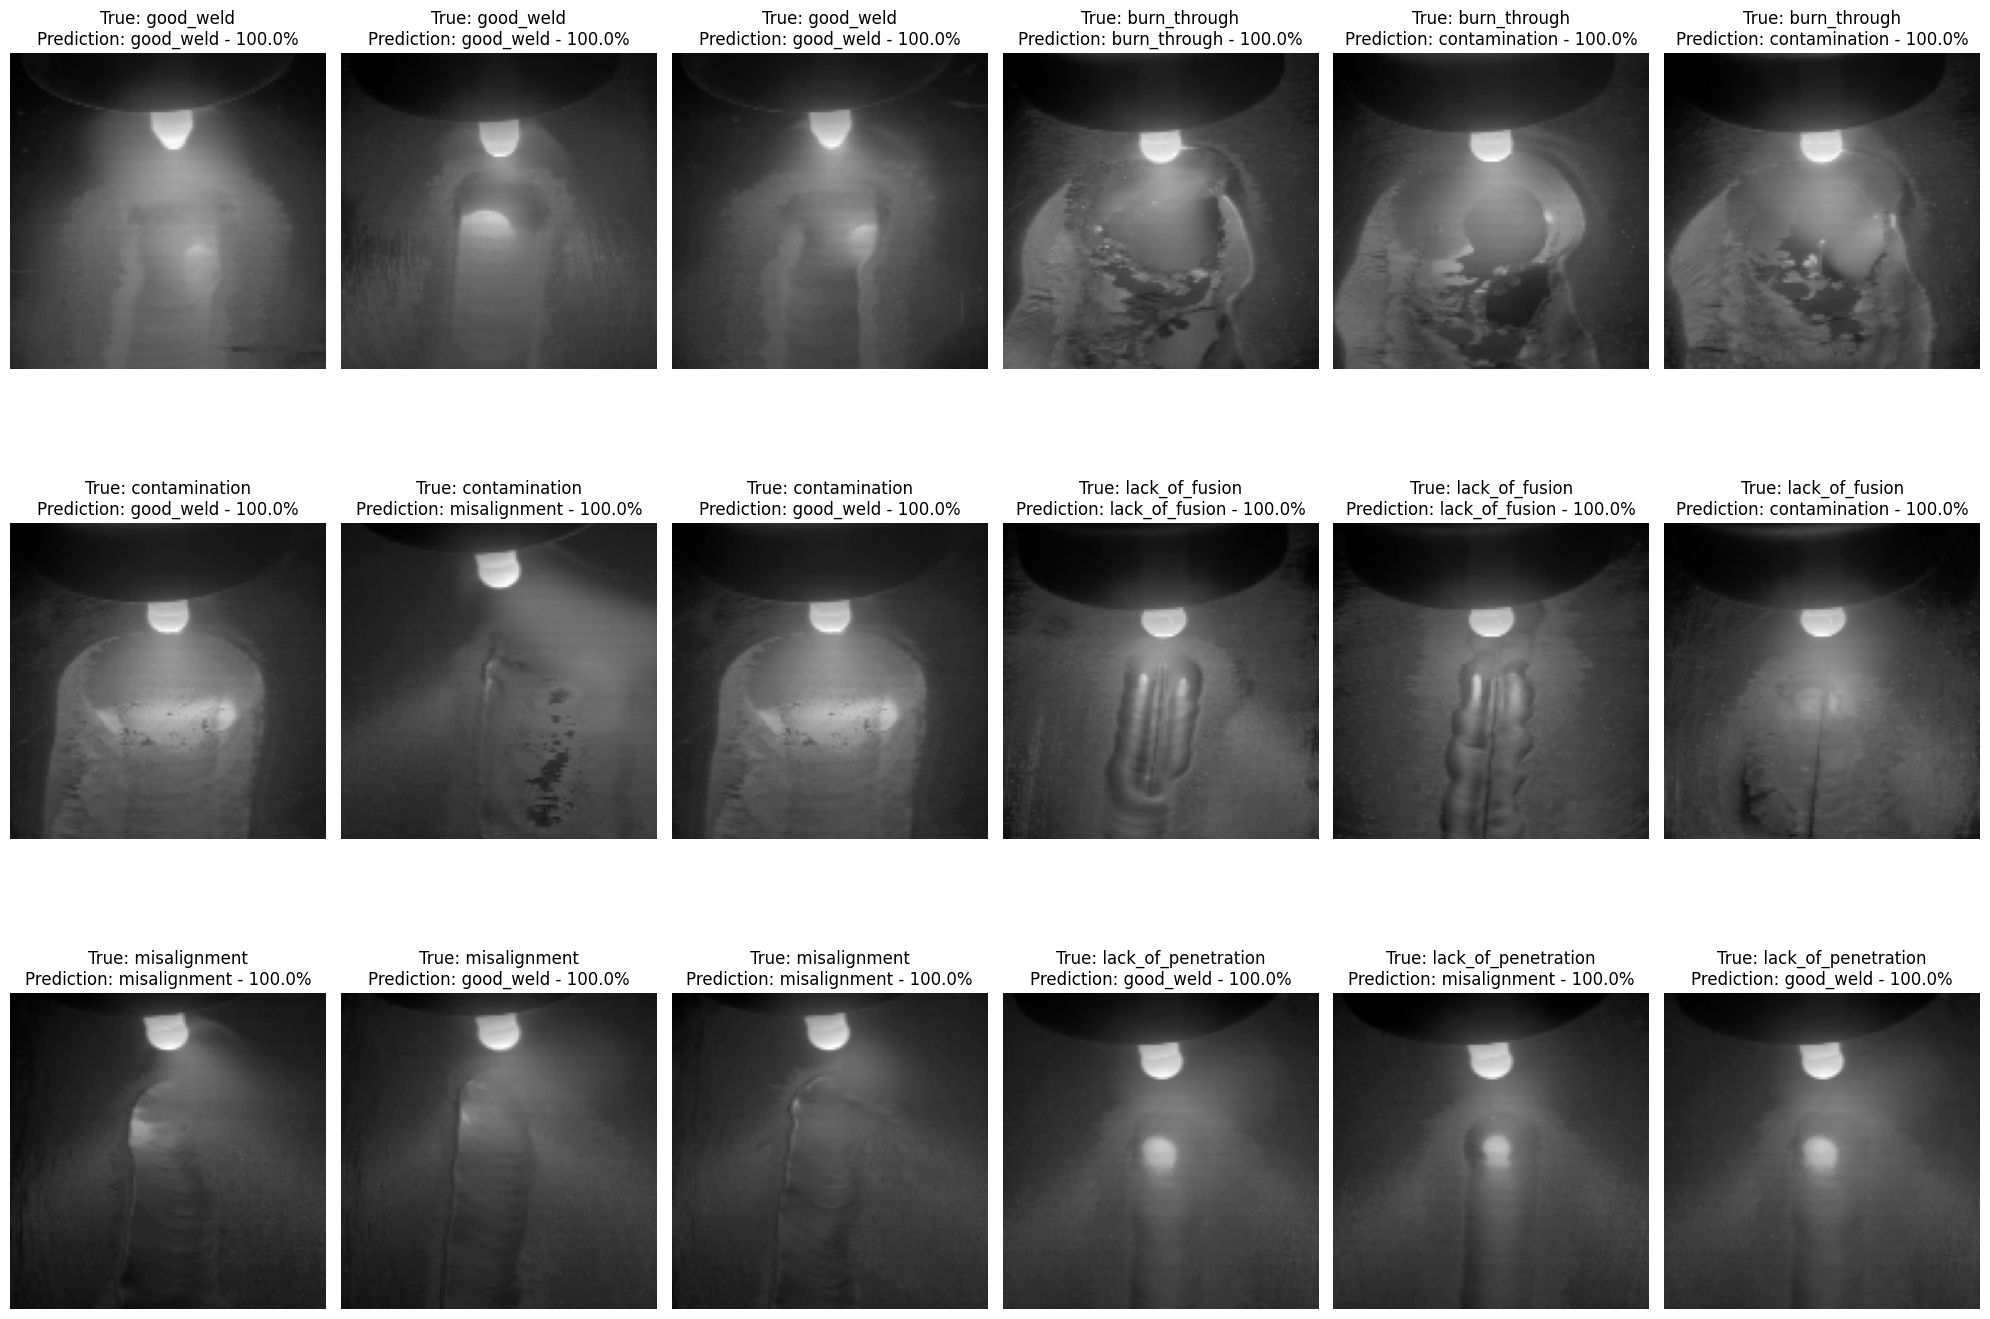

In [34]:
show_few_images(X = X_test, y = y_test, number_of_examples=3, predict_using_model = cnn_model)

# References
---

- [A. B. Rahman, M. Touhid Islam, M. R. Islam, M. Sohrawordi and M. N. Sultan, "Enhanced Brain Tumor Classification from MRI Images Using Deep Learning Model," 2023 26th International Conference on Computer and Information Technology (ICCIT), Cox's Bazar, Bangladesh, 2023, pp. 1-6, doi: 10.1109/ICCIT60459.2023.10441064. keywords: {Dimensionality reduction;Deep learning;Transfer learning;Feature extraction;Discrete wavelet transforms;Image classification;Tumors;Contrast Enhanced MRI(CE-MRI);Brain Tumor;Discrete Wavelet Transformation(DWT);CNN},](https://ieeexplore.ieee.org/document/10441064)

- [Daniel Bacioiu, Geoff Melton, Mayorkinos Papaelias, Rob Shaw,
Automated defect classification of Aluminium 5083 TIG welding using HDR camera and neural networks,
Journal of Manufacturing Processes,
Volume 45,
2019,
Pages 603-613,
ISSN 1526-6125,
https://doi.org/10.1016/j.jmapro.2019.07.020.
(https://www.sciencedirect.com/science/article/pii/S1526612519302245)
Abstract: Weld defect identification represents one of the most desired goals in the field of non-destructive testing (NDT) of welds. The current study investigates a system for assessing tungsten inert gas (TIG) welding using a high dynamic range (HDR) camera with the help of artificial neural networks (ANN) for image processing. This study proposes a new dataset11https://www.kaggle.com/danielbacioiu/tig-aluminium-5083. of images of the TIG welding process in the visible spectrum with improved contrast, similar to what a welder would normally see, and a model for computing a label identifying the welding imperfection. The progress (accuracy) achieved with the new system over varying degrees of categorisation complexity is thoroughly presented.
Keywords: Automation; Convolutional neural networks; HDR camera; Vision; Process monitoring; Quality assessment](https://www.sciencedirect.com/science/article/abs/pii/S1526612519302245)

**By**


Name: Asadullah Bin Rahman 

Email: [galib.cse.17020221@std.hstu.ac.bd](galib.cse.17020221@std.hstu.ac.bd) 

[Portfolio](https://asadullahgalib007.github.io/), [LinkedIn](https://www.linkedin.com/in/asadullah-bin-rahman/), [Google Scholar](https://scholar.google.com/citations?user=mhuUG2oAAAAJ&hl=en)